# Estimate Diffusion Angle
---
This notebook estimates Noisy [1,2] parameters from Gaussian Random Fields movies. More specifically, the Adjoint method is used to estimate the opening angle of the diffusion tensor.

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [2]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy as sci
from tqdm.notebook import tqdm
from scipy.optimize import minimize
import xarray as xr
from joblib import Parallel, delayed

In [2]:
class OpeningAngleOptimizer(object):
    def __init__(self, solver, measurements):
        self._nfeval = 0
        self.solver = solver
        self.measurements = measurements
        
    def objective_fun(self, x):
        self.solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x))
        random_field = self.solver.run_symmetric(verbose=False)
        error = random_field - self.measurements
        loss = (error**2).mean()
        
        self.solver.set_advection(-self.solver.advection)
        backprop = self.solver.run_symmetric(source=error, verbose=False)
        self.solver.set_advection(-self.solver.advection)
    
        dx = 1e-2
        solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x+dx))
        jac_source = solver.get_laplacian(random_field)
        solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=x))
        jac_source -= solver.get_laplacian(random_field)
        jac_source = jac_source / dx
        
        gradient = (backprop * jac_source).mean()
        return np.array(loss), np.array(gradient)

    def callback_fun(self, x):
        print('{}    {}'.format(self._nfeval, x))
        self._nfeval += 1
        
    def minimize(self, x0):
        result = minimize(fun=self.objective_fun, x0=np.array(x0), method='L-BFGS-B', jac=True)
        return result

## Forward Model

In [3]:
advection_true = pynoisy.advection.disk()
diffusion_true = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection_true, diffusion_true)
measurements = solver.run_symmetric(verbose=False)
measurements.to_netcdf('random_field_symetric.nc')

Synthetic measurements


<IPython.core.display.Javascript object>


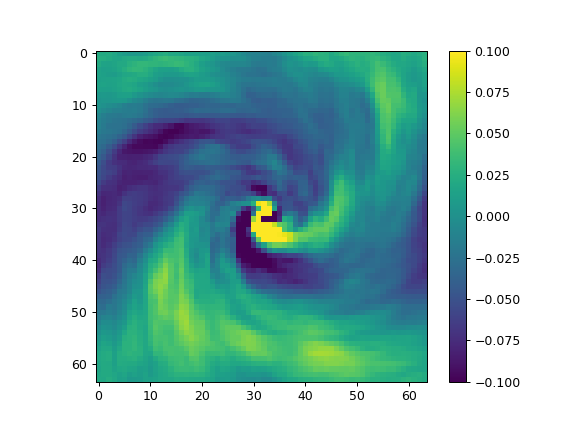

In [7]:
%matplotlib notebook
print('Synthetic measurements')
measurements.noisy_methods.get_animation(vmin=-0.1, vmax=0.1)

## Inverse Model (Fixed Known Noise)

In [7]:
"""
Load true random field generated previously
"""
measurements = xr.load_dataarray('random_field_symetric.nc')
advection_true = pynoisy.advection.disk()
diffusion_true = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection_true, diffusion_true)
solver.reseed(measurements.seed)

### Adjoint backpropogation

In [4]:
"""
Initilaize diffusion tensor angle with initial guess
"""
adjoint_solver = solver.copy()
adjoint_solver.set_diffusion(pynoisy.diffusion.ring(opening_angle=0.0))
adjoint_solver.reseed(measurements.seed)
random_field = adjoint_solver.run_symmetric()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:28<00:00, 28.95s/it]


Initial guess


<IPython.core.display.Javascript object>


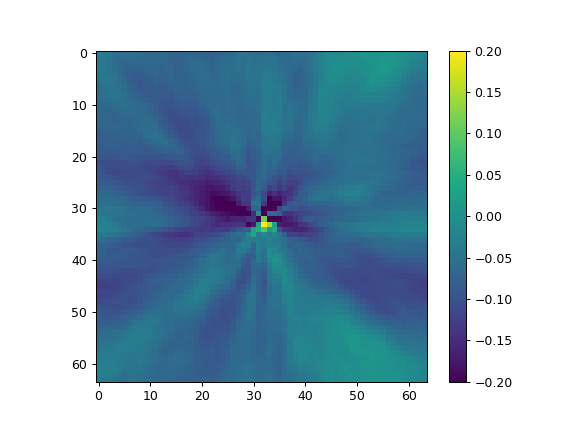

In [7]:
print('Initial guess')
%matplotlib notebook
random_field.noisy_methods.get_animation(vmin=-0.2, vmax=0.2)

In [5]:
"""
Compute error and backpropogate (Adjoint) error through Noisy
"""
error = random_field - measurements
adjoint_solver.set_advection(-solver.advection)
backprop = adjoint_solver.run_symmetric(source=error)

100%|██████████| 1/1 [00:15<00:00, 15.73s/it]


Error


<IPython.core.display.Javascript object>


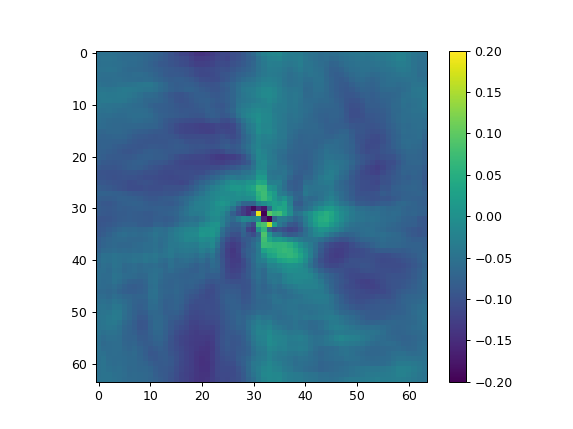

In [10]:
print('Error')
%matplotlib notebook
error.noisy_methods.get_animation(vmin=-0.2, vmax=0.2)

### Loss / gradient analysis

In [ ]:
def objective_fun1(x):
    diffusion = pynoisy.RingDiffusion(opening_angle=x)
    forward_solver = pynoisy.PDESolver(advection=advection_true, diffusion=diffusion)
    random_field = forward_solver.run_adjoint(source=source, verbose=False)
    error = random_field.frames - random_field_true.frames
    loss = np.abs(error).mean()
    return loss

def objective_fun3(x):
    diffusion = pynoisy.RingDiffusion(opening_angle=x)
    forward_solver = pynoisy.PDESolver(advection=advection_true, diffusion=diffusion)
    random_field = forward_solver.run_adjoint(source=source, verbose=False)
    error = random_field.frames - random_field_true.frames
    loss = np.abs(error).mean()

    dx = 1e-2
    diffusion_f = pynoisy.RingDiffusion(opening_angle=x+dx)
    jac_source = (diffusion_f.get_laplacian(random_field.frames, advection_true.v) - 
                  diffusion.get_laplacian(random_field.frames, advection_true.v)) / dx
    jacobian = forward_solver.run_adjoint(source=jac_source, verbose=False)
    gradient = np.mean(error * jacobian.frames)
    return loss, gradient
    
def objective_fun2(x):
    diffusion = pynoisy.RingDiffusion(opening_angle=x)
    forward_solver = pynoisy.PDESolver(advection=advection_true, diffusion=diffusion)
    adjoint_solver = pynoisy.PDESolver(advection=-advection_true, diffusion=diffusion)
    random_field = forward_solver.run_adjoint(source=source, verbose=False)
    error = random_field.frames - random_field_true.frames
    loss = np.abs(error).mean()
    #backprop = adjoint_solver.run_adjoint(source=pynoisy.Movie(error).reverse_time().frames, verbose=False)
    backprop = forward_solver.run_adjoint(source=error, verbose=False)
    
    dx = 1e-2
    diffusion_f = pynoisy.RingDiffusion(opening_angle=x+dx)
    jac_source = (diffusion_f.get_laplacian(random_field.frames, advection_true.v) - 
                  diffusion.get_laplacian(random_field.frames, advection_true.v)) / dx
    
    #gradient = np.mean(backprop.frames * np.flip(jac_source, axis=0))
    gradient = np.mean(backprop.frames * jac_source)
    return loss, gradient

In [ ]:
cost1, cost2 = [], []
grad1, grad2 = [], []
theta_grid = np.linspace(0.0, 1.1 + np.pi, 40)
dx = 1e-3
for x in tqdm(theta_grid):
    c, g = objective_fun2(x)
    cost2.append(c)
    grad2.append(g)
    grad1.append((objective_fun1(x+dx) - c) / dx)

In [ ]:
%matplotlib notebook 

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].set_xlabel(r'$\theta$')
ax[0].set_ylabel(r'$F(\theta)$')
ax[0].set_title('Loss function')
ax[0].plot(theta_grid, cost2, label='Loss')
ax[0].axvline(x=diffusion_true.opening_angle, label='True angle', color='r', linestyle='--')
ax[1].axvline(x=diffusion_true.opening_angle, label='True angle', color='r', linestyle='--')
ax[1].plot(theta_grid, grad1, label='Numerical gradient')
ax[1].plot(theta_grid, grad2, label='Adjoint gradient')
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel(r'$\nabla F(\theta)$')
ax[1].set_title('Gradient comparison')

plt.legend()

In [ ]:
%matplotlib notebook 

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].set_xlabel(r'$\theta$')
ax[0].set_ylabel(r'$F(\theta)$')
ax[0].set_title('Loss function')
ax[0].plot(theta_grid, cost2, label='Loss')
ax[0].axvline(x=diffusion_true.opening_angle,  color='r', linestyle='--')
ax[1].axvline(x=diffusion_true.opening_angle, color='r', linestyle='--')
ax[1].axhline(y=0, label='True angle', color='r', linestyle='--')
ax[1].plot(theta_grid, grad1, label='Numerical gradient')
ax[1].plot(theta_grid, np.array(grad2)*0.05, label='Adjoint gradient')
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel(r'$\nabla F(\theta)$')
ax[1].set_title('Gradient comparison')

plt.legend()

### Full Optimization

In [ ]:
"""
Optimization from many initial guesses. 
"""
optimizer = OpeningAngleOptimizer(solver, measurements)
x0_list = np.linspace(0.0, np.pi, 30)
results = []
for x0 in tqdm(x0_list):
    res = optimizer.minimize(x0)
    results.append(res.x)

<IPython.core.display.Javascript object>


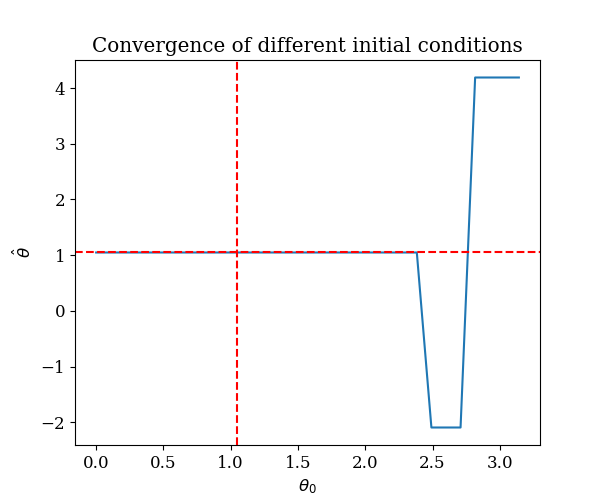

In [8]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\hat{\theta}$')
ax.set_title('Convergence of different initial conditions')
ax.plot(x0_list, np.array(results))
plt.axhline(y=diffusion_true.opening_angle, color='r', linestyle='--', label='True angle')
plt.axvline(x=diffusion_true.opening_angle, color='r', linestyle='--', label='True angle')

## Inverse Model (Unknown Noise - Krylov)

In [3]:
def run_optimization(x0, solver_true):
    
    # Without model error
    source = np.random.randn(solver_true.num_frames, *pynoisy.core.get_image_size()) * solver_true.forcing_strength
    measurements = solver_true.run_adjoint(source=source, verbose=False)
    
    optimizer = pynoisy.LBFGSbOptimizer(n_jobs=1)
    optimizer.set_measurements(measurements)
    
    # Setup unknowns
    initial_guess = pynoisy.RingDiffusion(opening_angle=x0)
    diffusion = pynoisy.RingDiffusionAngleEstimator(initial_guess)
    solver = pynoisy.PDESolver(advection_true, diffusion)
    optimizer.set_solver(solver)
    
    result = optimizer.minimize()
    
    return result.x

# Generate synthetic measurements
advection_true = pynoisy.DiskAdvection()
diffusion_true = pynoisy.RingDiffusion()
solver_true = pynoisy.PDESolver(advection_true, diffusion_true)

n_jobs = 12
x0_list = np.linspace(-np.pi/2, np.pi/2, 24)
results = Parallel(n_jobs=n_jobs)(
    delayed(run_optimization)(x0, solver_true) for x0 in tqdm(x0_list, desc='Initialization loop')
)

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


<IPython.core.display.Javascript object>


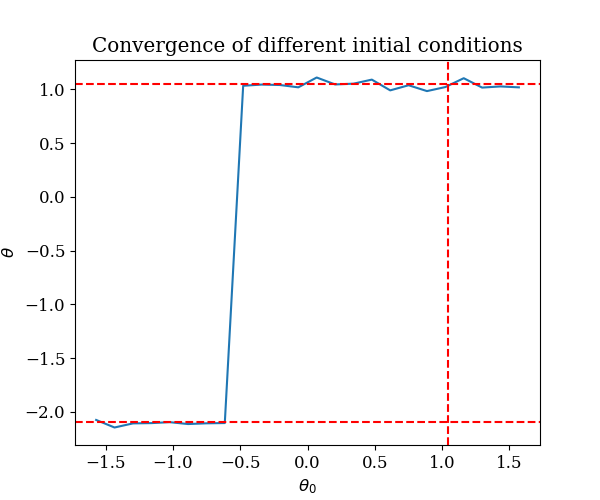

In [4]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\hat{\theta}$')
ax.set_title('Convergence of different initial conditions')
ax.plot(x0_list, np.array(results))
plt.axhline(y=diffusion_true.opening_angle, color='r', linestyle='--')
plt.axhline(y=diffusion_true.opening_angle - np.pi, color='r', linestyle='--')
plt.axvline(x=diffusion_true.opening_angle, color='r', linestyle='--')